## Extracting the soft-clipped reads in the CIC region (all breakpoints)
Using pysam 
pip install pysam, pandas, ncbi blast

In [ ]:
#importing packages
import sys
import os
import pysam
import pandas as pd
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
mport scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform, pdist
print(sys.executable)

/opt/conda/bin/python


In [ ]:
# set the base directory, here the aligned HiFi data has been stored in this directory before the incident
base_dir = "/lustre/scratch126/casm/team274sb/lr26/PacBio-aligned/"
# this is where the RNA data is located
rna_dir = "/lustre/scratch126/casm/team274sb/lr26/RNA"

In [ ]:
### here are all the functions to handling soft clipped sequences
# the first function extracts the soft clips which are longer than 20 nt if given the bam file, chromosome, start and end positions
def extract_soft_clipped_sequences(bamfile_path, chrom, start, end, min_length=20):
    soft_clipped_reads = []
    # read and handle the bam file with pysam 
    with pysam.AlignmentFile(bamfile_path, "rb") as bamfile:
        for read in bamfile.fetch(chrom, start, end):
            if read.is_unmapped:
                continue  # do not bother with unmapped reads
            strand = "-" if read.is_reverse else "+"  # retain the strand orientation
            cigar_tuples = read.cigartuples
            if not cigar_tuples:
                continue  # skip reads without cigar info
            # to store soft clipped sequence and aligned information - start and end of alignment
            soft_clipped_seq = None
            aligned_start = read.reference_start 
            aligned_end = read.reference_end 
            # the extraction of soft-clipped sequence
            if cigar_tuples[0][0] == 4: # this handles left soft clipping
                length = cigar_tuples[0][1]
                if length > min_length:  # and soft clips are filtered based on the length
                    soft_clipped_seq = read.query_sequence[:length]
            elif cigar_tuples[-1][0] == 4:  # this handles right soft clipping
                length = cigar_tuples[-1][1]
                if length > min_length:  # and soft clips are filtered based on the length
                    soft_clipped_seq = read.query_sequence[-length:]
            if soft_clipped_seq:
                # here I am storing the details of each sequence
                soft_clipped_reads.append((
                    read.query_name,  # read id
                    soft_clipped_seq,  # the soft clipped sequence
                    strand,  # strand either - or +
                    aligned_start,  # i also want to retain the info on where the aligned portion is
                    aligned_end,  # i also want to retain the info on where the aligned portion is
                    chrom  # chromosome
                ))
    return soft_clipped_reads

### this function takes all the soft clipped reads extracted above and saves them to a csv
# defining all the fieldnames (column names) as are defined above
def save_to_csv(soft_clipped_reads, file_path):
    with open(file_path, 'w', newline='') as csvfile:
        fieldnames = ['Read ID', 'Soft clipped sequence', 'Strand', 'Aligned Start', 'Aligned End', 'Chromosome']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for read_id, soft_clipped_seq, strand, aligned_start, aligned_end, chrom in soft_clipped_reads:
            writer.writerow({
                'Read ID': read_id,
                'Soft clipped sequence': soft_clipped_seq,
                'Strand': strand,
                'Aligned Start': aligned_start,
                'Aligned End': aligned_end,
                'Chromosome': chrom
            })

# this function takes care of the read IDs which have slashes (puts underscores)
def sanitize_read_id(read_id):
    return read_id.replace("/", "_")

# this function converts the sequences into a fasta format
def save_to_fasta(read_id, sequence):
    # firstly make sure to sanitise the read IDs to prevent file path confusion
    sanitized_read_id = sanitize_read_id(read_id)
    # ensire the fasta directory exists before saving to there
    os.makedirs(fasta_dir, exist_ok=True)
    # the fasta file will be defined by the read id for each read
    fasta_filename = f"{fasta_dir}/{sanitized_read_id}.fasta"
    # this one takes the sequence formats it and saves the fasta file
    with open(fasta_filename, "w") as fasta_file:
        fasta_file.write(f"> {sanitized_read_id}\n{sequence}\n")
    return fasta_filename

# this function takes a csv and reformats it into a fasta 
def convert_csv_to_fasta(csv_file, fasta_dir):
    with open(csv_file, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            read_id = row['Read ID']
            sequence = row['Soft clipped sequence']
            # Call save_to_fasta to save each sequence as a FASTA file
            save_to_fasta(read_id, sequence)

In [ ]:
# so then to use the functions above, I can define:
# the bam file path, chromosome and region of interest (through the CIC breakpoints)
bamfile_path = (base_dir + "tumor_all_4_hifi_reads_pbmm2.bam")
chromosome = "chr19"
start, end = 45055000, 45160000 
# then from this I can extract the soft clipped sequences using these definitions
soft_clipped_seqs = extract_soft_clipped_sequences(bamfile_path, chromosome, start, end, min_length=20)
# I can save them to a csv file
save_to_csv(soft_clipped_seqs, base_dir + "soft_clipped_sequences_chr19-new.csv")
# I can load again the csv file in and define the output fasta directory
csv_file = base_dir + "soft_clipped_sequences_chr19-new.csv"
fasta_dir = base_dir + "fasta"
# and then I can use the convertion function to make the fasta directory and populate it with fasta files of soft clipped annotated sequences
convert_csv_to_fasta(csv_file, fasta_dir)

### THEN I CAN USE blat-chr19.sh to carry out the blat search of the top 5 results per read
### with this input I can also use the blast-chr19.sh to fun the BLAST search of top 5 results per read

In [ ]:
# similarly, I would also define other regions of interest on other chromosomes:
bamfile_path = (base_dir + "tumor_all_4_hifi_reads_pbmm2.bam")
chromosome = "chr10"
start, end = 952000, 983400
soft_clipped_seqs = extract_soft_clipped_sequences(bamfile_path, chromosome, start, end, min_length=20)
# I can save them to a csv file
save_to_csv(soft_clipped_seqs, base_dir + "soft_clipped_sequences_chr10-new.csv")
# I can load again the csv file in and define the output fasta directory
csv_file = base_dir + "soft_clipped_sequences_chr10-new.csv"
fasta_dir = base_dir + "fasta-chr10"
# and then I can use the convertion function to make the fasta directory and populate it with fasta files of soft clipped annotated sequences
convert_csv_to_fasta(csv_file, fasta_dir)

### THEN I CAN USE blat-chr10.sh to carry out the blat search of the top 5 results per read

In [ ]:
# similarly, I would also define other regions of interest on other chromosomes:
bamfile_path = (base_dir + "tumor_all_4_hifi_reads_pbmm2.bam")
chromosome = "chr1"
start, end = 128421200, 128422200
soft_clipped_seqs = extract_soft_clipped_sequences(bamfile_path, chromosome, start, end, min_length=20)
# I can save them to a csv file
save_to_csv(soft_clipped_seqs, base_dir + "soft_clipped_sequences_chr1-inner.csv")
# I can load again the csv file in and define the output fasta directory
csv_file = base_dir + "soft_clipped_sequences_chr1-inner.csv"
fasta_dir = base_dir + "fasta-chr1-inner"
# and then I can use the convertion function to make the fasta directory and populate it with fasta files of soft clipped annotated sequences
convert_csv_to_fasta(csv_file, fasta_dir)

### THEN I CAN USE blat-chr1-inner.sh to carry out the blat search of the top 5 results per read

In [ ]:
# similarly, I would also define other regions of interest on other chromosomes:
bamfile_path = (base_dir + "tumor_all_4_hifi_reads_pbmm2.bam")
chromosome = "chr1"
start, end = 128460000, 128570000
soft_clipped_seqs = extract_soft_clipped_sequences(bamfile_path, chromosome, start, end, min_length=20)
# I can save them to a csv file
save_to_csv(soft_clipped_seqs, base_dir + "soft_clipped_sequences_chr1-upstream.csv")
# I can load again the csv file in and define the output fasta directory
csv_file = base_dir + "soft_clipped_sequences_chr1-upstream.csv"
fasta_dir = base_dir + "fasta-chr1-upstream"
# and then I can use the convertion function to make the fasta directory and populate it with fasta files of soft clipped annotated sequences
convert_csv_to_fasta(csv_file, fasta_dir)

### THEN I CAN USE blat-chr1-upstream.sh to carry out the blat search of the top 5 results per read

In [ ]:
# I CAN USE THE SAME APPROACH FOR RNA or DNA 
bamfile_path = (rna_dir + "final_merged.bam")
chromosome = "chr19"
start, end = 45114510, 45114610  
soft_clipped_seqs = extract_soft_clipped_sequences(bamfile_path, chromosome, start, end, min_length=20)
# I can save them to a csv file
save_to_csv(soft_clipped_seqs, rna_dir + "soft_clipped_sequences_rna.csv")
# I can load again the csv file in and define the output fasta directory
csv_file = rna_dir + "soft_clipped_sequences_rna.csv"
fasta_dir = rna_dir + "fasta-rna"
# and then I can use the convertion function to make the fasta directory and populate it with fasta files of soft clipped annotated sequences
convert_csv_to_fasta(csv_file, fasta_dir)

### THEN I CAN USE blat-rna.sh to carry out the blat search of the top 2 results per read

In [ ]:
### these are a couple of functions that post-process the blat output
# again the function to sanitize the read IDs in the read information file
# that has not been sanitised yet
def sanitize_read_id(read_id):
    return read_id.replace("/", "_").strip()

# here I am loading the information from the read info file skipping the header
# I am sanitizing read IDs and storing a few metrics that I need, the original read ID
# by which I will match the soft clipped sequence, the initial strand, start and end of the 
# original chromosome where the non soft clipped part of the read is 

def load_read_info(read_info_file):
    read_info = {}
    with open(read_info_file, mode='r', newline='') as infile:
        reader = csv.reader(infile)
        header_info = next(reader) 
        print("Header of read_info file:", header_info)  # debugging print
        for row in reader:
            if len(row) < 6:
                continue  # skip rows which do not have everything
            read_id = row[0].strip()
            seq = row[1].strip()
            strand = row[2].strip()
            start = row[3].strip()
            end = row[4].strip()
            chrom = row[5].strip()
            sanitized_id = sanitize_read_id(read_id)
            read_info[sanitized_id] = (seq, strand, start, end, chrom)
    return read_info

# here I am defining the new updated column names and I am adding them to the blat result file
# I am using the sanitised read IDs to match the information from both files
def merge_read_info_into_blat(read_info, blat_result_file):
    updated_data = []
    with open(blat_result_file, mode='r', newline='') as infile:
        reader = csv.reader(infile)
        header_blat = next(reader)
        updated_data.append(header_blat + ['Sequence_Init', 'Strand_Init', 'Start_Init', 'End_Init', 'Chr_Init'])
        for row in reader:
            if len(row) == 0:
                continue
            raw_read_id = row[0].strip()
            read_id = sanitize_read_id(raw_read_id)
            if read_id in read_info:
                seq, strand, start, end, chrom = read_info[read_id]
                new_row = row + [seq, strand, start, end, chrom]
            else:
                new_row = row + ['', '', '', '', '']
            updated_data.append(new_row)
    return updated_data

# then I am saving the newly updated blat file
def write_merged_csv(output_file, data):
    with open(output_file, mode='w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerows(data)
    print(f" updated blat result saved to {output_file}")

# this is the main processing function which uses all the previous functions
def process_blat_results(read_info_file, blat_result_file, output_file):
    read_info = load_read_info(read_info_file)
    merged_data = merge_read_info_into_blat(read_info, blat_result_file)
    write_merged_csv(output_file, merged_data)

In [ ]:
# I then use this to make the updated blat file - here an example for chromosome 19 breakpoints
blat_result_file = base_dir + "blat_top5-parallel.csv"
read_info_file = base_dir + "soft_clipped_sequences_chr19-new.csv"
output_file = base_dir + "updated_blat_top5_chr19-parallel.csv"

# I read int the csv and create the dict to map the read ID values and save the updated blat
process_blat_results(read_info_file, blat_result_file, output_file)

# I can repeat this process for all remaining blat or BLAST files

In [ ]:
# load in the updated blat top5 for chr19 (same can be done with the rna results)
pb = pd.read_csv(base_dir + "updated_blat_top5_chr19-parallel.csv", sep = ",")
# print the shape
print(pb.shape)
# no of insertions - how good the blat was
# and other useful stats
print(pb['qNumInsert'].sum())
print(pb['Chromosome'].value_counts())
print(pb['Start.1'].value_counts())
print(pb['End.1'].value_counts())
print(pb['Query_Start'].value_counts())
print(len(pb["Read_ID"].unique()))

In [ ]:
# groups data by chromosome and counts how many times each query start appears
qstart_distribution = pb.groupby('Chromosome')['Query_Start'].value_counts()
print(qstart_distribution)
# filters for the most frequenct query starts
qstart_filtered = qstart_distribution[qstart_distribution > 10]
print(qstart_filtered)

# gets the first alignment per read
pb_new = pb.groupby("Read_ID").first()
# crepeating the occurrences counts of each qStart_1 value for each tName_1
qstart_counts = pb_new.groupby('Chromosome')['Query_Start'].value_counts()
print(qstart_counts)
# filters for the most frequenct query starts
qstart_filtered = qstart_counts[qstart_counts > 10].reset_index(name='reads')

# merges with original sequence starts and ends from pb dataframe
qstart_filtered = pb_new.merge(pb_new[['Query_Start', 'Start.1', 'End.1']], on='Query_Start', how='left')
# count occurrences of each start-end combination - define them here
start_end_counts = pb[pb["End.1"]==45114512.0].groupby(['Chromosome','Start.1', 'End.1', 'Query_Start']).size().reset_index(name='Count')
print(start_end_counts)

In [ ]:
# this part is to test which of the breakpoint coordinates have which orientation (are they starts or ends)
# not that meaningful, mostly used to divide soft clips into groups 
# here drop all the NaN values for start and end (all should have start and end)
pb_filtered = pb.dropna(subset=['Start_Init', 'End_Init']).copy()

# convert to integers
pb_filtered['Start_Init'] = pb_filtered['Start_Init'].astype(int)
pb_filtered['End_Init'] = pb_filtered['End_Init'].astype(int)

# define groups by start and end coordinates for the breakpoints
start_values = {45085571, 45085569, 45150884, 45150883}
end_values = {45114512, 45114507, 45062732, 45062733}

# filter depending on whether something matches
filtered_pb = pb_filtered[(pb_filtered['Start_Init'].isin(start_values)) | 
                           (pb_filtered['End_Init'].isin(end_values))]

# count how many starts occur dividing by strand
start_counts = filtered_pb[filtered_pb['Start_Init'].isin(start_values)].groupby(['Start_Init', 'Strand_Init']).size().unstack(fill_value=0)

# count how many times ends occur dividing by strand
end_counts = filtered_pb[filtered_pb['End_Init'].isin(end_values)].groupby(['End_Init', 'Strand_Init']).size().unstack(fill_value=0)

In [ ]:
## here is the division into distinct groups depending on breakpoints
# here I define the four groups of start and end values
# depending on their breakpoint orientation (start or end)
group_1_start = {45085571, 45085569}
group_2_start = {45150884, 45150883}
group_3_end = {45114512, 45114507}
group_4_end = {45062732, 45062733}

# filtering the data for each group
group_1 = pb_filtered[pb_filtered['Start_Init'].isin(group_1_start)]
group_2 = pb_filtered[pb_filtered['Start_Init'].isin(group_2_start)]
group_3 = pb_filtered[pb_filtered['End_Init'].isin(group_3_end)]
group_4 = pb_filtered[pb_filtered['End_Init'].isin(group_4_end)]

# how many reads belong to each group
print(f"Group 1 (Start: {group_1_start}): {group_1.shape}")
print(f"Group 2 (Start: {group_2_start}): {group_2.shape}")
print(f"Group 3 (End: {group_3_end}): {group_3.shape}")
print(f"Group 4 (End: {group_4_end}): {group_4.shape}")

# then I save into separate csv files based on group
group_1.to_csv(base_dir + "group_45085571-69blat.csv", index=False)
group_2.to_csv(base_dir + "group_45150884-3blat.csv", index=False)
group_3.to_csv(base_dir + "group_45114507-12blat.csv", index=False)
group_4.to_csv(base_dir + "group_45062732-3blat.csv", index=False)

In [ ]:
# read in the filtered separated group based blat results
group_4508 = pd.read_csv(base_dir + "group_45085571-69blat.csv", sep = ",")
group_4515 = pd.read_csv(base_dir + "group_45150884-3blat.csv", sep = ",")
group_4511 = pd.read_csv(base_dir + "group_45114507-12blat.csv", sep = ",")
group_4506 = pd.read_csv(base_dir + "group_45062732-3blat.csv", sep = ",")

# count occurrences of each Start and End per strand
# producing frequency tables for each start or end values (pivot) including the strands - roughly a 1:1 split if no copy number changes
start_counts_4506 = group_4506[group_4506['tStart'].isin(start_values)].groupby(['tStart', 'strand']).size().unstack(fill_value=0)
end_counts_4506 = group_4506[group_4506['tEnd'].isin(end_values)].groupby(['tEnd', 'strand']).size().unstack(fill_value=0)
print(start_counts_4506, end_counts_4506)

start_counts_4508 = group_4508[group_4508['tStart'].isin(start_values)].groupby(['tStart', 'strand']).size().unstack(fill_value=0)
end_counts_4508 = group_4508[group_4508['tEnd'].isin(end_values)].groupby(['tEnd', 'strand']).size().unstack(fill_value=0)
print(start_counts_4508, end_counts_4508)

start_counts_4511 = group_4511[group_4511['tStart'].isin(start_values)].groupby(['tStart', 'strand']).size().unstack(fill_value=0)
end_counts_4511 = group_4511[group_4511['tEnd'].isin(end_values)].groupby(['tEnd', 'strand']).size().unstack(fill_value=0)
print(start_counts_4511, end_counts_4511)

start_counts_4515 = group_4515[group_4515['tStart'].isin(start_values)].groupby(['tStart', 'strand']).size().unstack(fill_value=0)
end_counts_4515 = group_4515[group_4515['tEnd'].isin(end_values)].groupby(['tEnd', 'strand']).size().unstack(fill_value=0)
print(start_counts_4515, end_counts_4515)

In [ ]:
# here I print the descriptive statistics per each group
# will be able to see the numbers for each of the top 5 hits
group_4506_new = group_4506
print(group_4506_new['tName'].value_counts())
print(group_4506_new['tEnd'].value_counts())
print(group_4506_new['qStart'].value_counts())
print(group_4506_new['strand'].value_counts())

group_4508_new = group_4508
print(group_4508_new['tName'].value_counts())
print(group_4508_new['tStart'].value_counts())
print(group_4508_new['qStart'].value_counts())
print(group_4508_new['strand'].value_counts())

group_4511_new = group_4511
print(group_4511_new['tName'].value_counts())
print(group_4511_new['tStart'].value_counts())
print(group_4511_new['qStart'].value_counts())
print(group_4511_new['strand'].value_counts())

group_4515_new = group_4515
print(group_4515_new['tName'].value_counts())
print(group_4515_new['tStart'].value_counts())
print(group_4515_new['qStart'].value_counts())
print(group_4515_new['strand'].value_counts())

In [ ]:
# these are individual snippets that aggregate results for each locus
# I load the breakpoint blat results
file_path = base_dir + "group_45062732-3blat.csv"
df = pd.read_csv(file_path, sep=",")
# and then I filter by the desired breakpoint starts which are these discovered in the code above
df_filtered = df[(df["End_Init"] == 45062733) | (df["End_Init"] == 45062732)].copy()
# then I look at how long the query was
df_filtered["Read_Length"] = df_filtered["qEnd"] - df_filtered["qStart"]
# I group by key desired stats: target chromosome, end, and strand while keeping read length and and strand
# here I select only the first ones since this breakpoint is rather clear
grouped = df_filtered.groupby(["tName", "strand", "tEnd"]).agg(
    tStart=("tStart", "first"),
    Query_start=("qStart", "first"),
    Query_end=("qEnd", "first"),
    Read_Count=("qName", "count"),
    Avg_Read_Length=("Read_Length", "mean")
).reset_index()
# save the resulting table as the csv file
output_path = base_dir + "mapping_counts_45062732-3blat.csv"
grouped.to_csv(output_path, index=False)

In [ ]:
# doing the same for the other breakpoints
file_path = base_dir + "group_45150884-3blat.csv"
df = pd.read_csv(file_path, sep=",")
df_filtered = df[(df["Start_Init"] == 45150884) | (df["Start_Init"] == 45150883)].copy()
df_filtered["Read_Length"] = df_filtered["qEnd"] - df_filtered["qStart"]
grouped = df_filtered.groupby(["tName", "strand", "tStart"]).agg(
    tEnd=("tEnd", "first"), 
    Query_start=("qStart", "first"),
    Query_end=("qEnd", "first"), 
    Read_Count=("qName", "count"), 
    Avg_Read_Length=("Read_Length", "mean")
).reset_index()
output_path = base_dir + "mapping_counts_45150884-3blat.csv"
grouped.to_csv(output_path, index=False)

In [ ]:
file_path = base_dir + "group_45085571-69blat.csv" 
df = pd.read_csv(file_path, sep=",")
df_filtered = df[(df["Start_Init"] == 45085571) | (df["Start_Init"] == 45085569)].copy()
# Compute query read length
df_filtered["Read_Length"] = df_filtered["qEnd"] - df_filtered["qStart"]
# Group by target chromosome, end, and strand while keeping Read_Length and Strand_Init
grouped = df_filtered.groupby(["tName", "strand", "tStart"]).agg(
    tEnd=("tEnd", "first"), 
    Query_start=("qStart", "first"), 
    Query_end=("qEnd", "first"),
    Read_Count=("qName", "count"),  
    Avg_Read_Length=("Read_Length", "mean")
).reset_index()
output_path = base_dir + "mapping_counts_45085571-69blat.csv"
grouped.to_csv(output_path, index=False)


In [ ]:
# this is the CIC exon 21 breakpoint - spurious one where I would like to keep the top 2 hits
file_path = base_dir + "group_45114507-12blat.csv"
df = pd.read_csv(file_path, sep=",")
df_filtered = df[(df["End_Init"] == 45114507) | (df["End_Init"] == 45114512)].copy()
df_filtered["Read_Length"] = df_filtered["qEnd"] - df_filtered["qStart"]
grouped_all = df_filtered.groupby(["tName", "strand", "tStart"]).agg(
    tEnd=("tEnd", "first"),
    Query_start=("qStart", "first"),
    Query_end=("qEnd", "first"),
    Read_Count=("qName", "count"),
    Avg_Read_Length=("Read_Length", "mean")
).reset_index()

# filter for groups with more than 1 read
grouped_all = grouped_all[grouped_all["Read_Count"] > 1]
# for each tName and strand I get the top 2 tStart values by read count
top2_per_group = (
    grouped_all
    .sort_values(['tName', 'strand', 'Read_Count'], ascending=[True, True, False])
    .groupby(['tName', 'strand'])
    .head(2)  # keep the top 2 rows per group which inclyde the query starts and ends
    .reset_index(drop=True)
)
# I save the result
output_path = base_dir + "mapping_counts_45114507-12blat_top2.csv"
top2_per_group.to_csv(output_path, index=False)

# then I screenshotted the table which is seen in the thesis for this breakpoint
# BLAST results I have analysed analogously with the approapriate column names in place
### I have done just aggregated counting of the read destinations for the RNA

## This part is used after the pairwise genome-wide D4Z4 repeat search
It includes visualizations with heatmaps and working with the d4z4-blast-t2t.sh output

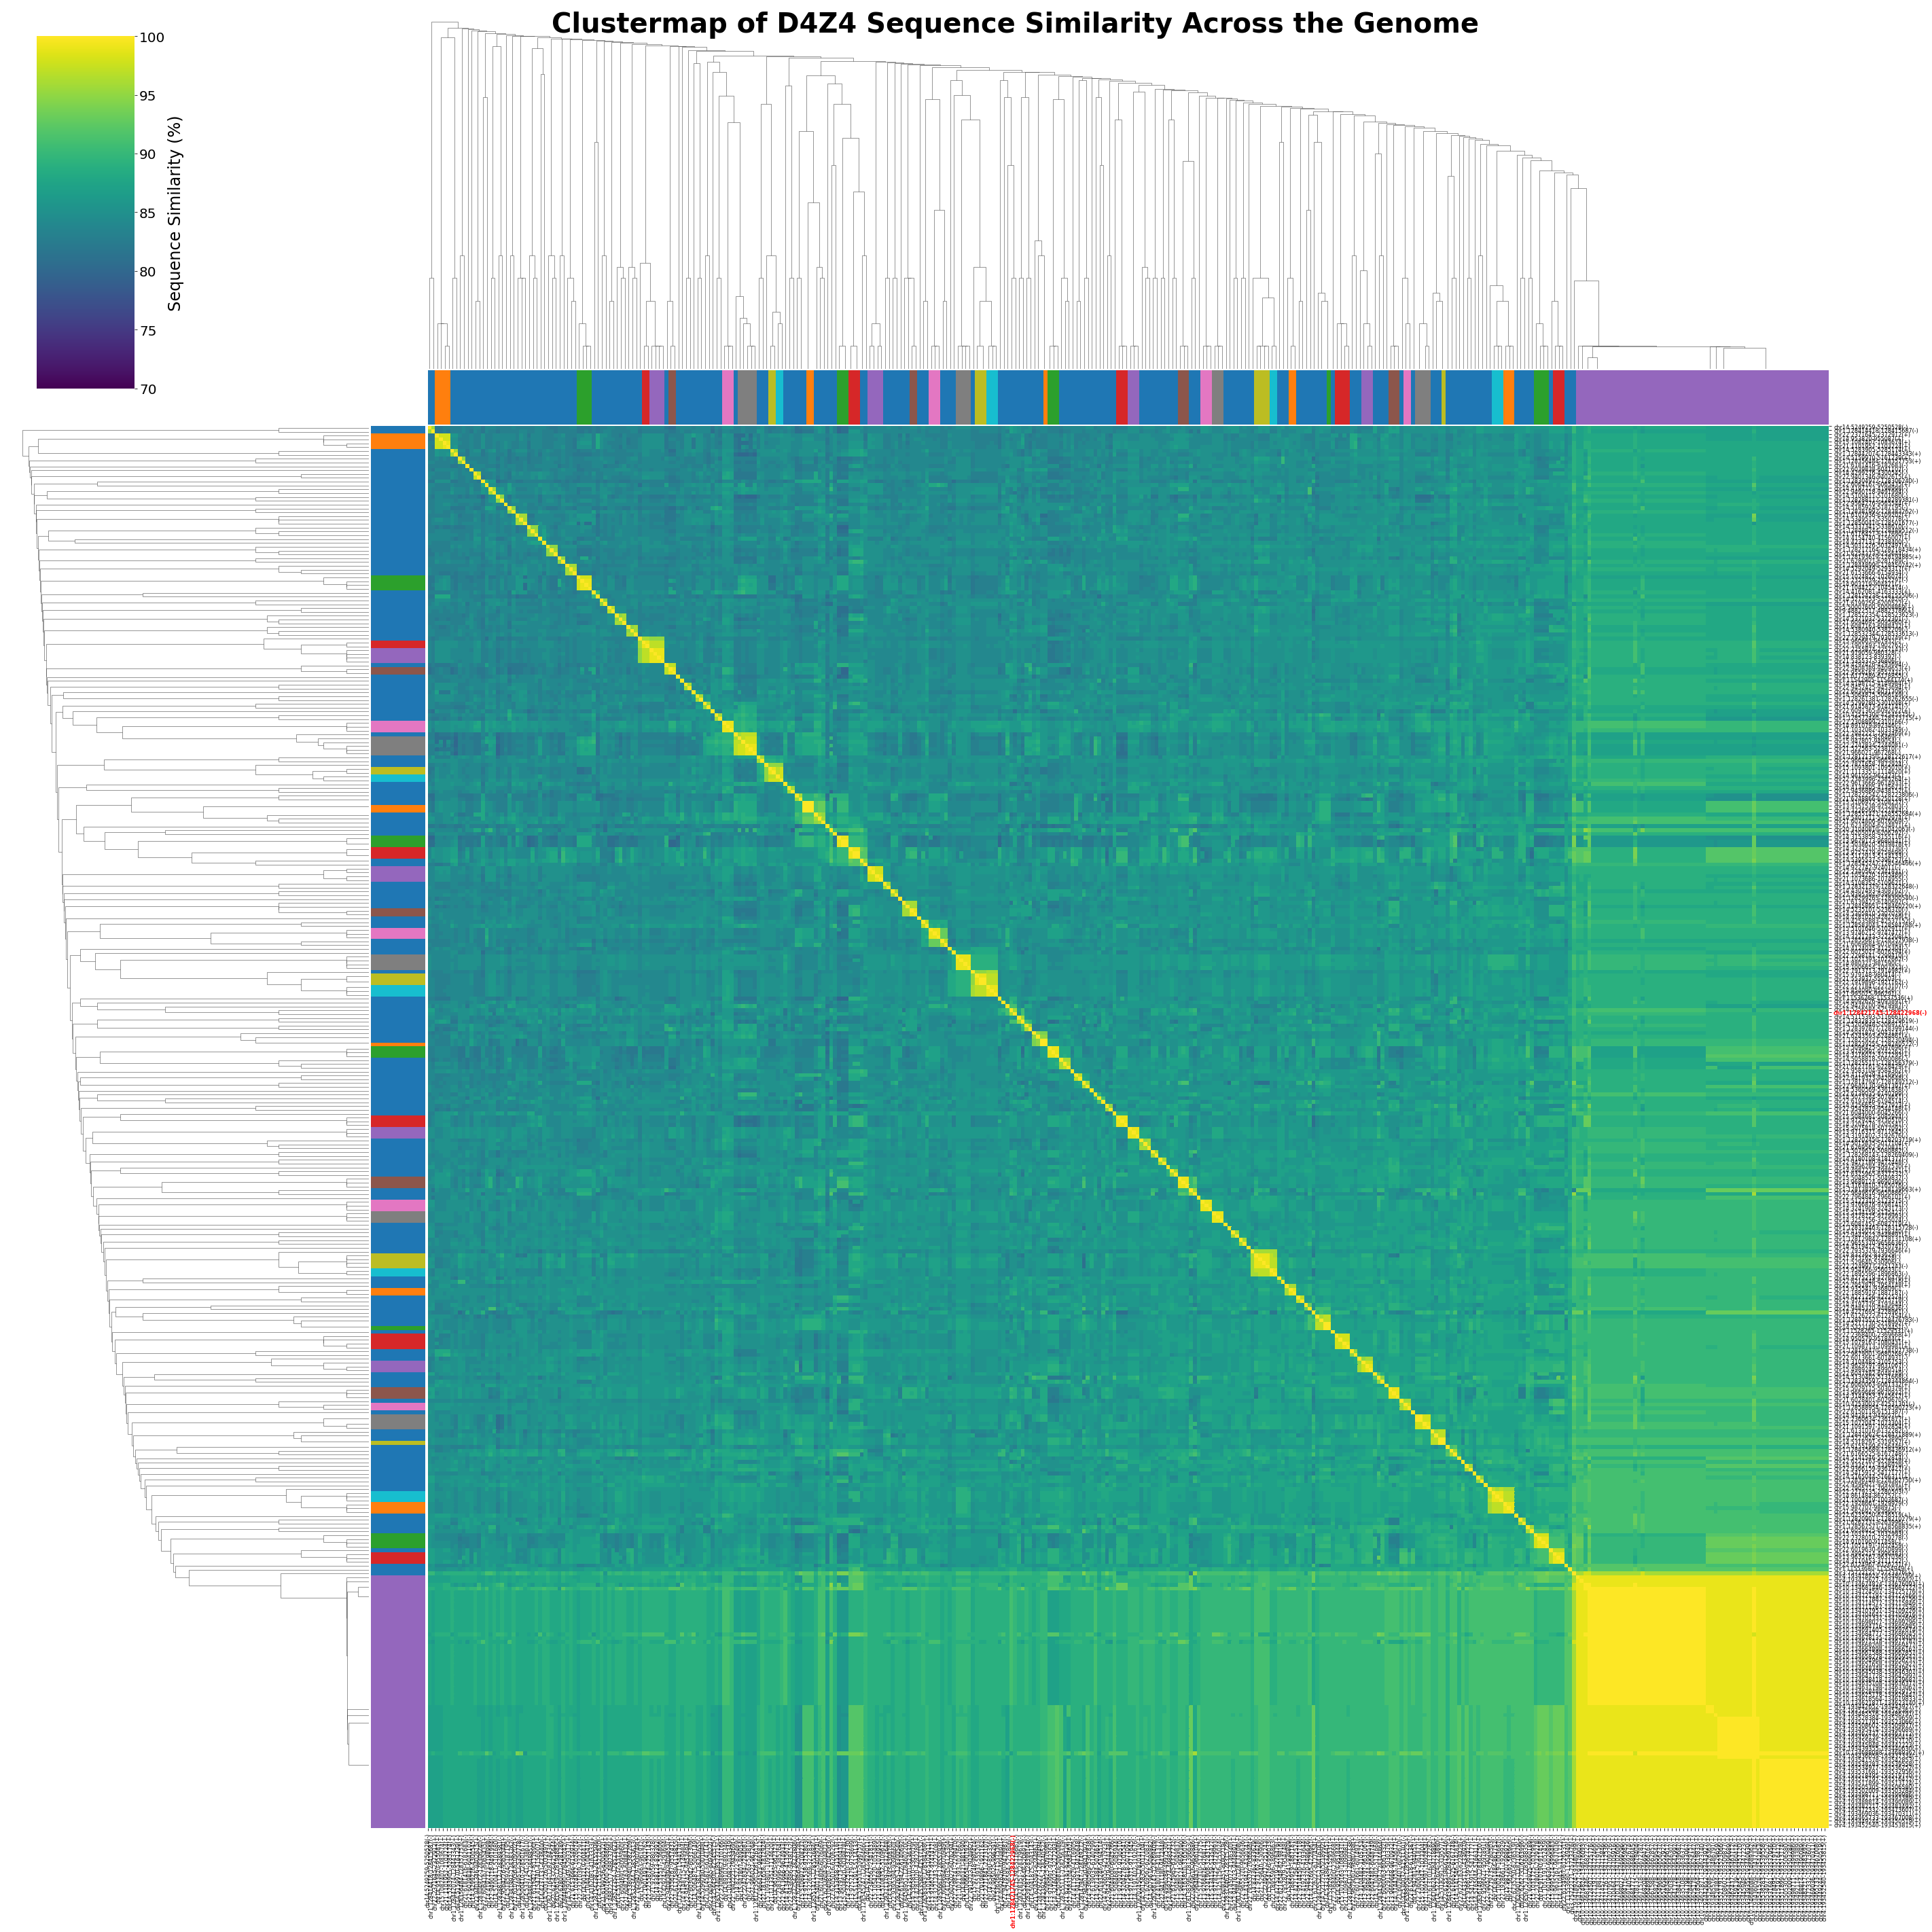

In [ ]:
# This is the code used for visualisation of the D4Z4 heatmaps across the genome
# first I define the sequence of interest where the rearrangement is
sequence_of_interest = "chr1:128421745-128422968(-)"

# then I load the blast output dataframe naming the columns appropriatelly
columns = ["Query_ID", "Subject_ID", "%_Identity", "Alignment_Length",
           "Mismatches", "Gap_Openings", "Query_Start", "Query_End", 
           "Subject_Start", "Subject_End", "E-value", "Bit_Score"]
df = pd.read_csv("/lustre/scratch126/casm/team274sb/lr26/T2T/d4z4_sequences_all_with_all.tsv", 
                 sep="\t", names=columns)

#  I extract the individual sequences
unique_sequences = sorted(set(df["Query_ID"]).union(set(df["Subject_ID"])))

# I create an empty dataframe with baseline 70 to store the sequences 
heatmap_df = pd.DataFrame(70, index=unique_sequences, columns=unique_sequences)

#  and then I fill it with the actual identity values found by blast 
# creating a similarity matrix (so the same but flipped)
for _, row in df.iterrows():
    heatmap_df.at[row["Query_ID"], row["Subject_ID"]] = row["%_Identity"]
    heatmap_df.at[row["Subject_ID"], row["Query_ID"]] = row["%_Identity"]  

# since blast gives percentages I convert to a distance metric between 0-1 values 
distance_matrix = 1 - (heatmap_df / 100)

#  then I perform hierarchical clustering of the sequences using the 'average' method
condensed_dist = squareform(distance_matrix)
Z = sch.linkage(condensed_dist, method="average")  

# I would like to have the dentrogram colors dynamic so I define a dynamic threshold
threshold = 0.15 * max(Z[:, 2])  
dendro = sch.dendrogram(Z, no_plot=True, color_threshold=threshold)

# and assign colors before plotting, then map them to match the correct order of the heatmap df
row_colors_dict = {leaf: color for leaf, color in zip(dendro["leaves"], dendro["leaves_color_list"])}
row_colors = [row_colors_dict[i] for i in range(len(heatmap_df))]  # Ensure ordering matches

#  I make the seaborn clustermap, dendrogram on both sides using viridis and the scale of 70-90
g = sns.clustermap(
    heatmap_df, 
    row_linkage=Z, 
    col_linkage=Z,  
    cmap="viridis", 
    linewidths=0,  
    figsize=(40, 40),
    cbar_kws={'label': 'Sequence Similarity (%)'},
    vmin=70, vmax=100,
    row_colors=row_colors,  # and I color it
    col_colors=row_colors  
)

#  get the correct order of labels from clustering
row_labels = [heatmap_df.index[i] for i in g.dendrogram_row.reordered_ind]
col_labels = [heatmap_df.columns[i] for i in g.dendrogram_col.reordered_ind]

#  put labels in the correct order to the x and y axes, rotate the x appropriately
g.ax_heatmap.set_yticks(np.arange(len(row_labels)))  
g.ax_heatmap.set_yticklabels(row_labels, fontsize=8)
g.ax_heatmap.set_xticks(np.arange(len(col_labels)))  
g.ax_heatmap.set_xticklabels(col_labels, fontsize=8, rotation=90)

# label the axes and put size
g.ax_cbar.set_ylabel("Sequence Similarity (%)", fontsize=24) 
g.ax_cbar.tick_params(labelsize=20) 

# make sure seaborn displays the labels
plt.setp(g.ax_heatmap.get_xticklabels(), visible=True)  
plt.setp(g.ax_heatmap.get_yticklabels(), visible=True)

#  highlight the sequence of interest in red and make the label larger
for label in g.ax_heatmap.get_yticklabels():
    if label.get_text() == sequence_of_interest:
        label.set_color("red")
        label.set_fontweight("bold")
        label.set_fontsize(8)  
for label in g.ax_heatmap.get_xticklabels():
    if label.get_text() == sequence_of_interest:
        label.set_color("red")
        label.set_fontweight("bold")
        label.set_fontsize(8)  

# name the thing
plt.title("Clustermap of D4Z4 Sequence Similarity Across the Genome", fontsize=40, fontweight='bold', y=1, x=10)
# save and display the thing
plt.savefig("/lustre/scratch126/casm/team274sb/lr26/T2T/d4z4_heatmap_clusters_fixed.pdf", dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
# here is the repeated approach just for chromosomes 1, 4 and 10 
# I need to first carry out subsetting for chr1, chr10 and chr4
# define the chromosomes
target_chromosomes = {"chr4", "chr1", "chr10"}

# load the dataset again
columns = ["Query_ID", "Subject_ID", "%_Identity", "Alignment_Length",
           "Mismatches", "Gap_Openings", "Query_Start", "Query_End", 
           "Subject_Start", "Subject_End", "E-value", "Bit_Score"]
df = pd.read_csv("/lustre/scratch126/casm/team274sb/lr26/T2T/d4z4_sequences_all_with_all.tsv", sep="\t", names=columns)

# function to extract the chromosome names from the sequence ids
def extract_chromosome(seq_id):
    return seq_id.split(":")[0]  # note I need to get chrX from chrX:XXXXX-XXXXX(+), everything before the :

# then I apply it to get the chr names across both comparisons (columns)
df["Query_Chr"] = df["Query_ID"].apply(extract_chromosome)
df["Subject_Chr"] = df["Subject_ID"].apply(extract_chromosome)

# I keep only those containing chr 1, 4, 10
filtered_df = df[(df["Query_Chr"].isin(target_chromosomes)) & 
                 (df["Subject_Chr"].isin(target_chromosomes))]
# and drop the extra ones
filtered_df = filtered_df.drop(columns=["Query_Chr", "Subject_Chr"])
# save the subset and use it for the heatmap below
filtered_df.to_csv("/lustre/scratch126/casm/team274sb/lr26/T2T/d4z4_sequences_chr1,4,10_all_with_all.tsv", sep="\t", index=False)


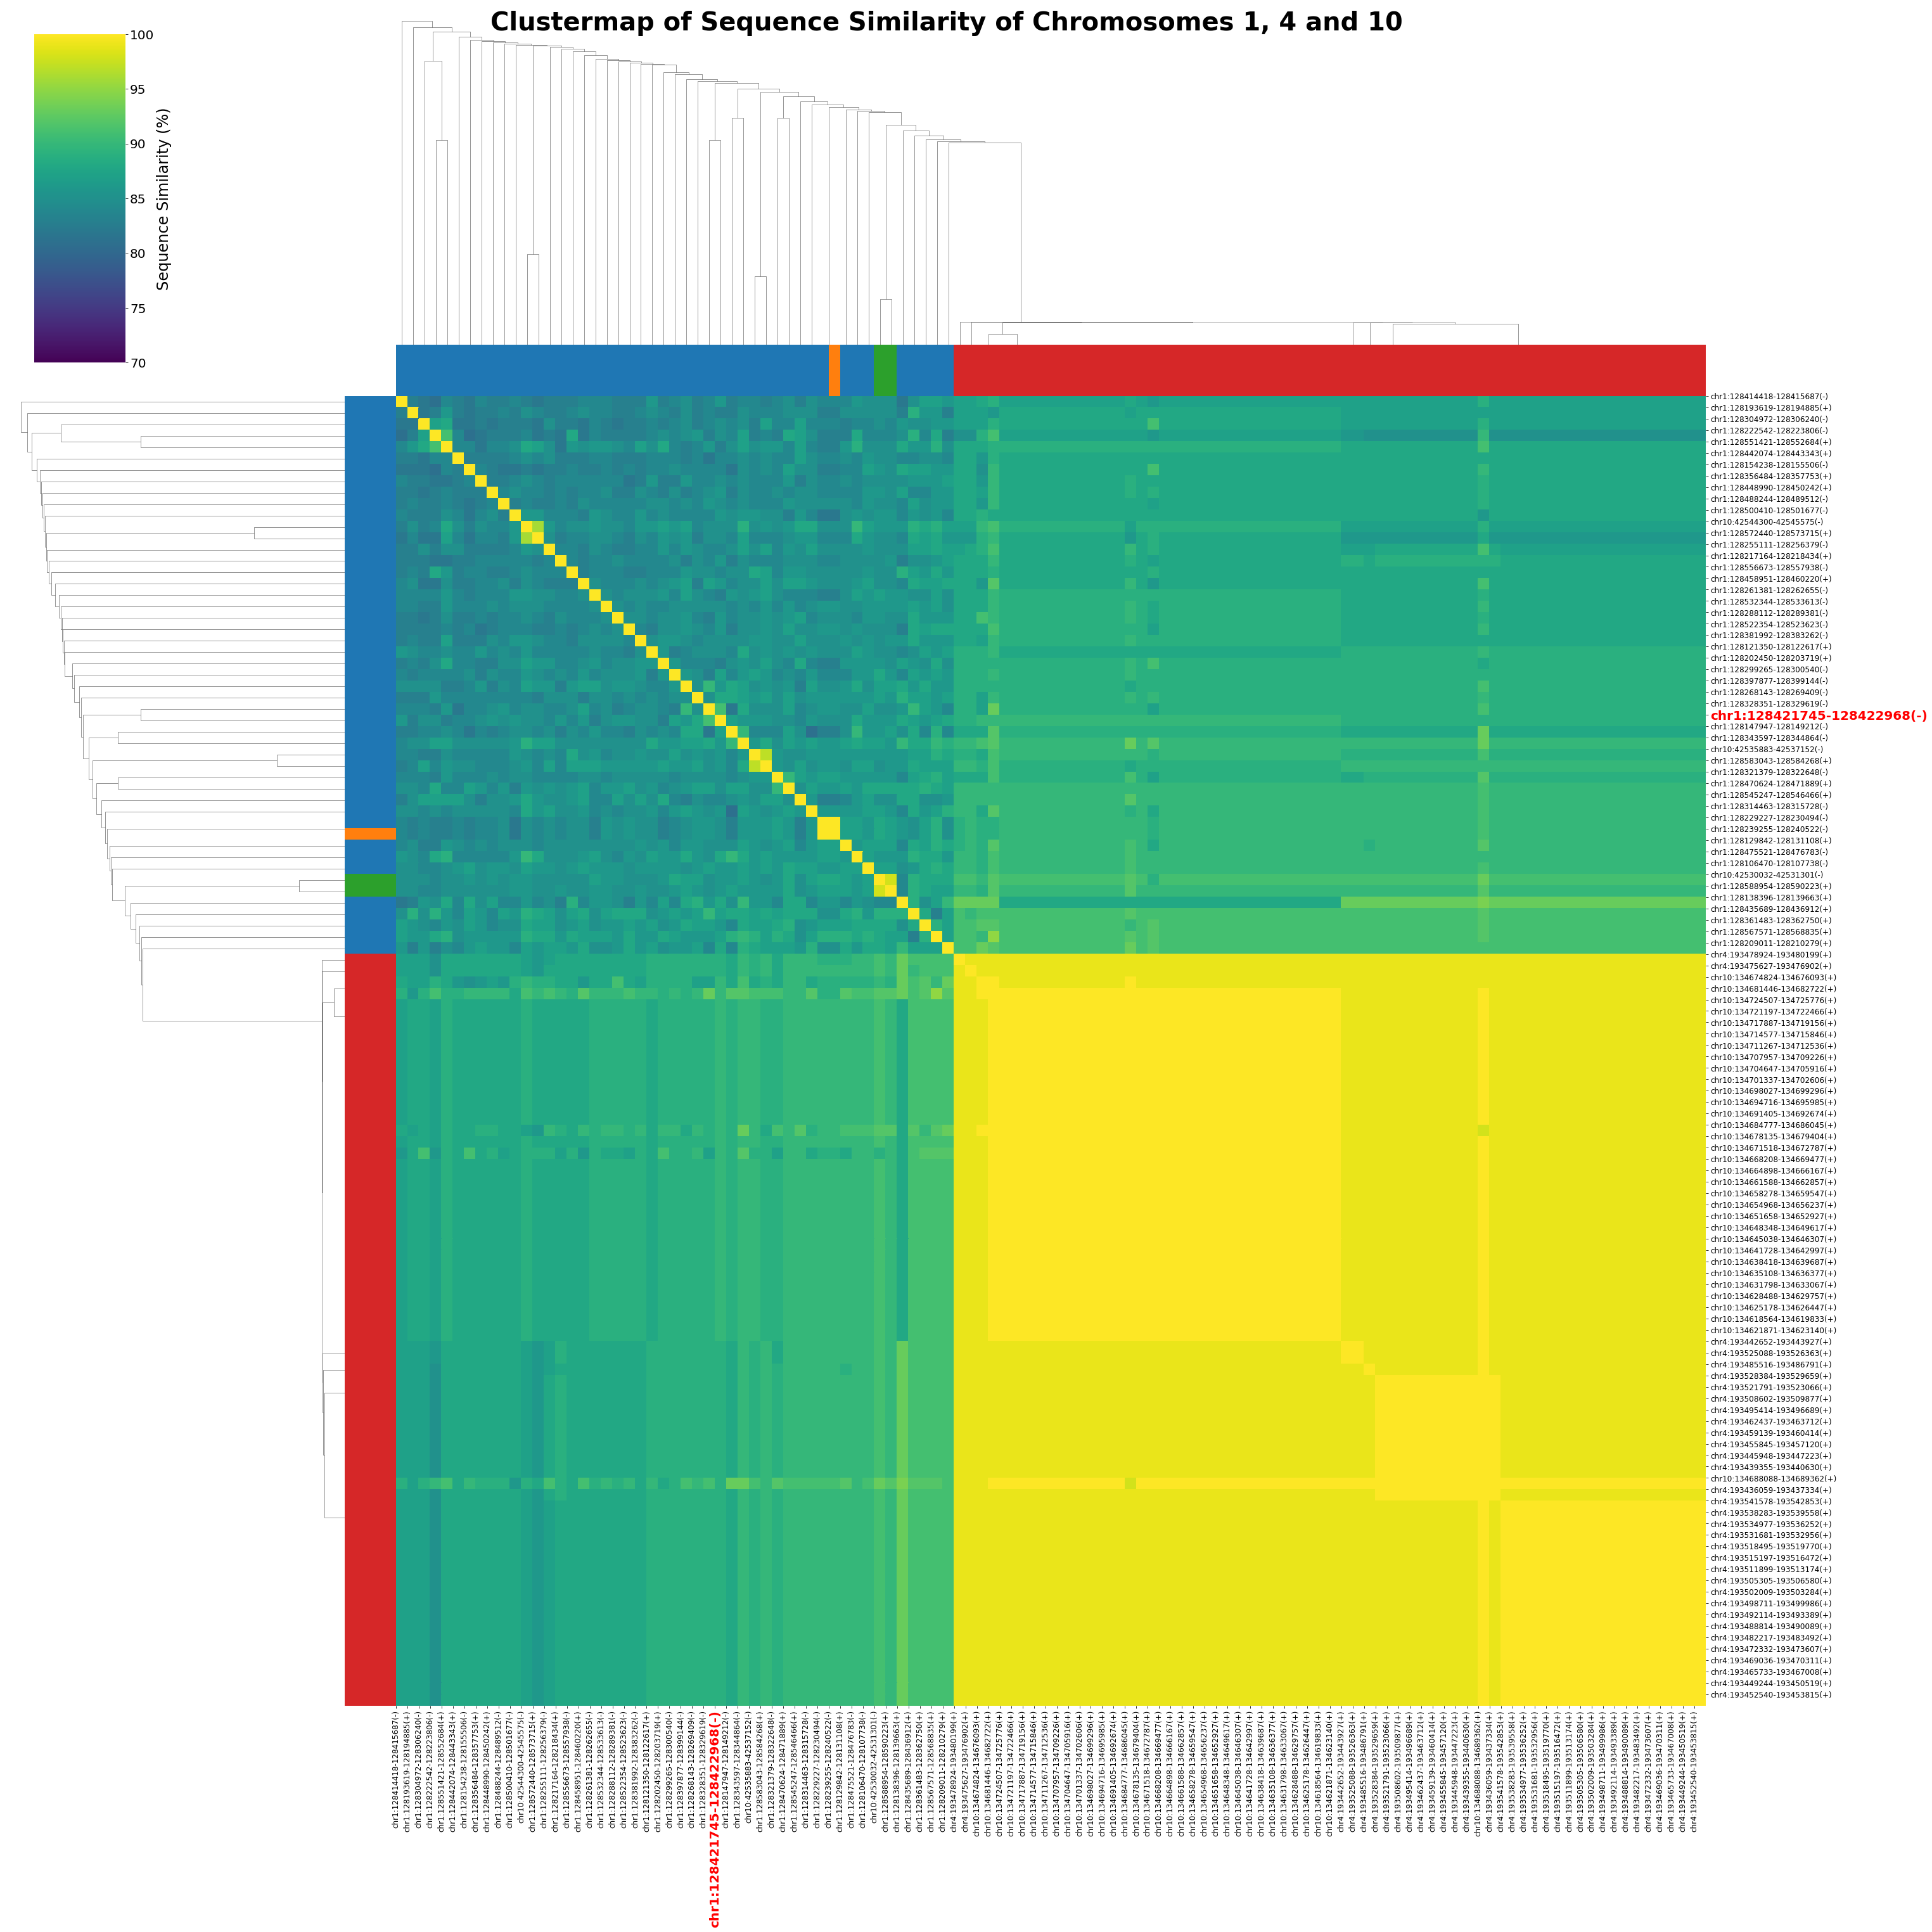

In [ ]:
# again the sequence of interest
sequence_of_interest = "chr1:128421745-128422968(-)"

# load the df making sure all of the numbers are floats
df = pd.read_csv("/lustre/scratch126/casm/team274sb/lr26/T2T/d4z4_sequences_chr1,4,10_all_with_all.tsv", 
                 sep="\t")
df["%_Identity"] = pd.to_numeric(df["%_Identity"], errors="coerce") 

# extract unique sequence names
unique_sequences = sorted(set(df["Query_ID"]).union(set(df["Subject_ID"])))

# create the similarity matrix (df)
heatmap_df = pd.DataFrame(70, index=unique_sequences, columns=unique_sequences)

# fill it with the blast identities ensuring it is filled from both sides
for _, row in df.iterrows():
    heatmap_df.at[row["Query_ID"], row["Subject_ID"]] = row["%_Identity"]
    heatmap_df.at[row["Subject_ID"], row["Query_ID"]] = row["%_Identity"] 

# convert the values to a 0-1 number
distance_matrix = 1 - (heatmap_df / 100)

# hierarchical clustering
condensed_dist = squareform(distance_matrix)
Z = sch.linkage(condensed_dist, method="average")  

# dynamic color threshold and dendrogram colors, assign them correctly before plotting and map them in correct order
threshold = 0.15 * max(Z[:, 2])  
dendro = sch.dendrogram(Z, no_plot=True, color_threshold=threshold)
row_colors_dict = {leaf: color for leaf, color in zip(dendro["leaves"], dendro["leaves_color_list"])}
row_colors = [row_colors_dict[i] for i in range(len(heatmap_df))] 

# make the seaborn map
g = sns.clustermap(
    heatmap_df, 
    row_linkage=Z, 
    col_linkage=Z,  
    cmap="viridis", 
    linewidths=0,  
    figsize=(40, 40),
    cbar_kws={'label': 'Sequence Similarity (%)'},
    vmin=70, vmax=100,
    row_colors=row_colors,
    col_colors=row_colors  
)

# ensure correct label order and that all of the labels are visible with the desired font size and position
row_labels = [heatmap_df.index[i] for i in g.dendrogram_row.reordered_ind]
col_labels = [heatmap_df.columns[i] for i in g.dendrogram_col.reordered_ind]
g.ax_heatmap.set_yticks(np.arange(len(row_labels)))  
g.ax_heatmap.set_yticklabels(row_labels, fontsize=12)
g.ax_heatmap.set_xticks(np.arange(len(col_labels)))  
g.ax_heatmap.set_xticklabels(col_labels, fontsize=12, rotation=90)

# label axes and ticks
g.ax_cbar.set_ylabel("Sequence Similarity (%)", fontsize=24)
g.ax_cbar.tick_params(labelsize=20) 

# make again sure that they are visible
plt.setp(g.ax_heatmap.get_xticklabels(), visible=True)  
plt.setp(g.ax_heatmap.get_yticklabels(), visible=True)

# make sequence of interest extra pretty
for label in g.ax_heatmap.get_yticklabels():
    if label.get_text() == sequence_of_interest:
        label.set_color("red")
        label.set_fontweight("bold")
        label.set_fontsize(20)  
for label in g.ax_heatmap.get_xticklabels():
    if label.get_text() == sequence_of_interest:
        label.set_color("red")
        label.set_fontweight("bold")
        label.set_fontsize(20)  

# name the map, save and display
plt.title("Clustermap of Sequence Similarity of Chromosomes 1, 4 and 10", fontsize=40, fontweight='bold', y=1, x=10)
plt.savefig("/lustre/scratch126/casm/team274sb/lr26/T2T/d4z4_heatmap_clusters_subset.pdf", dpi=300, bbox_inches='tight')
plt.show()

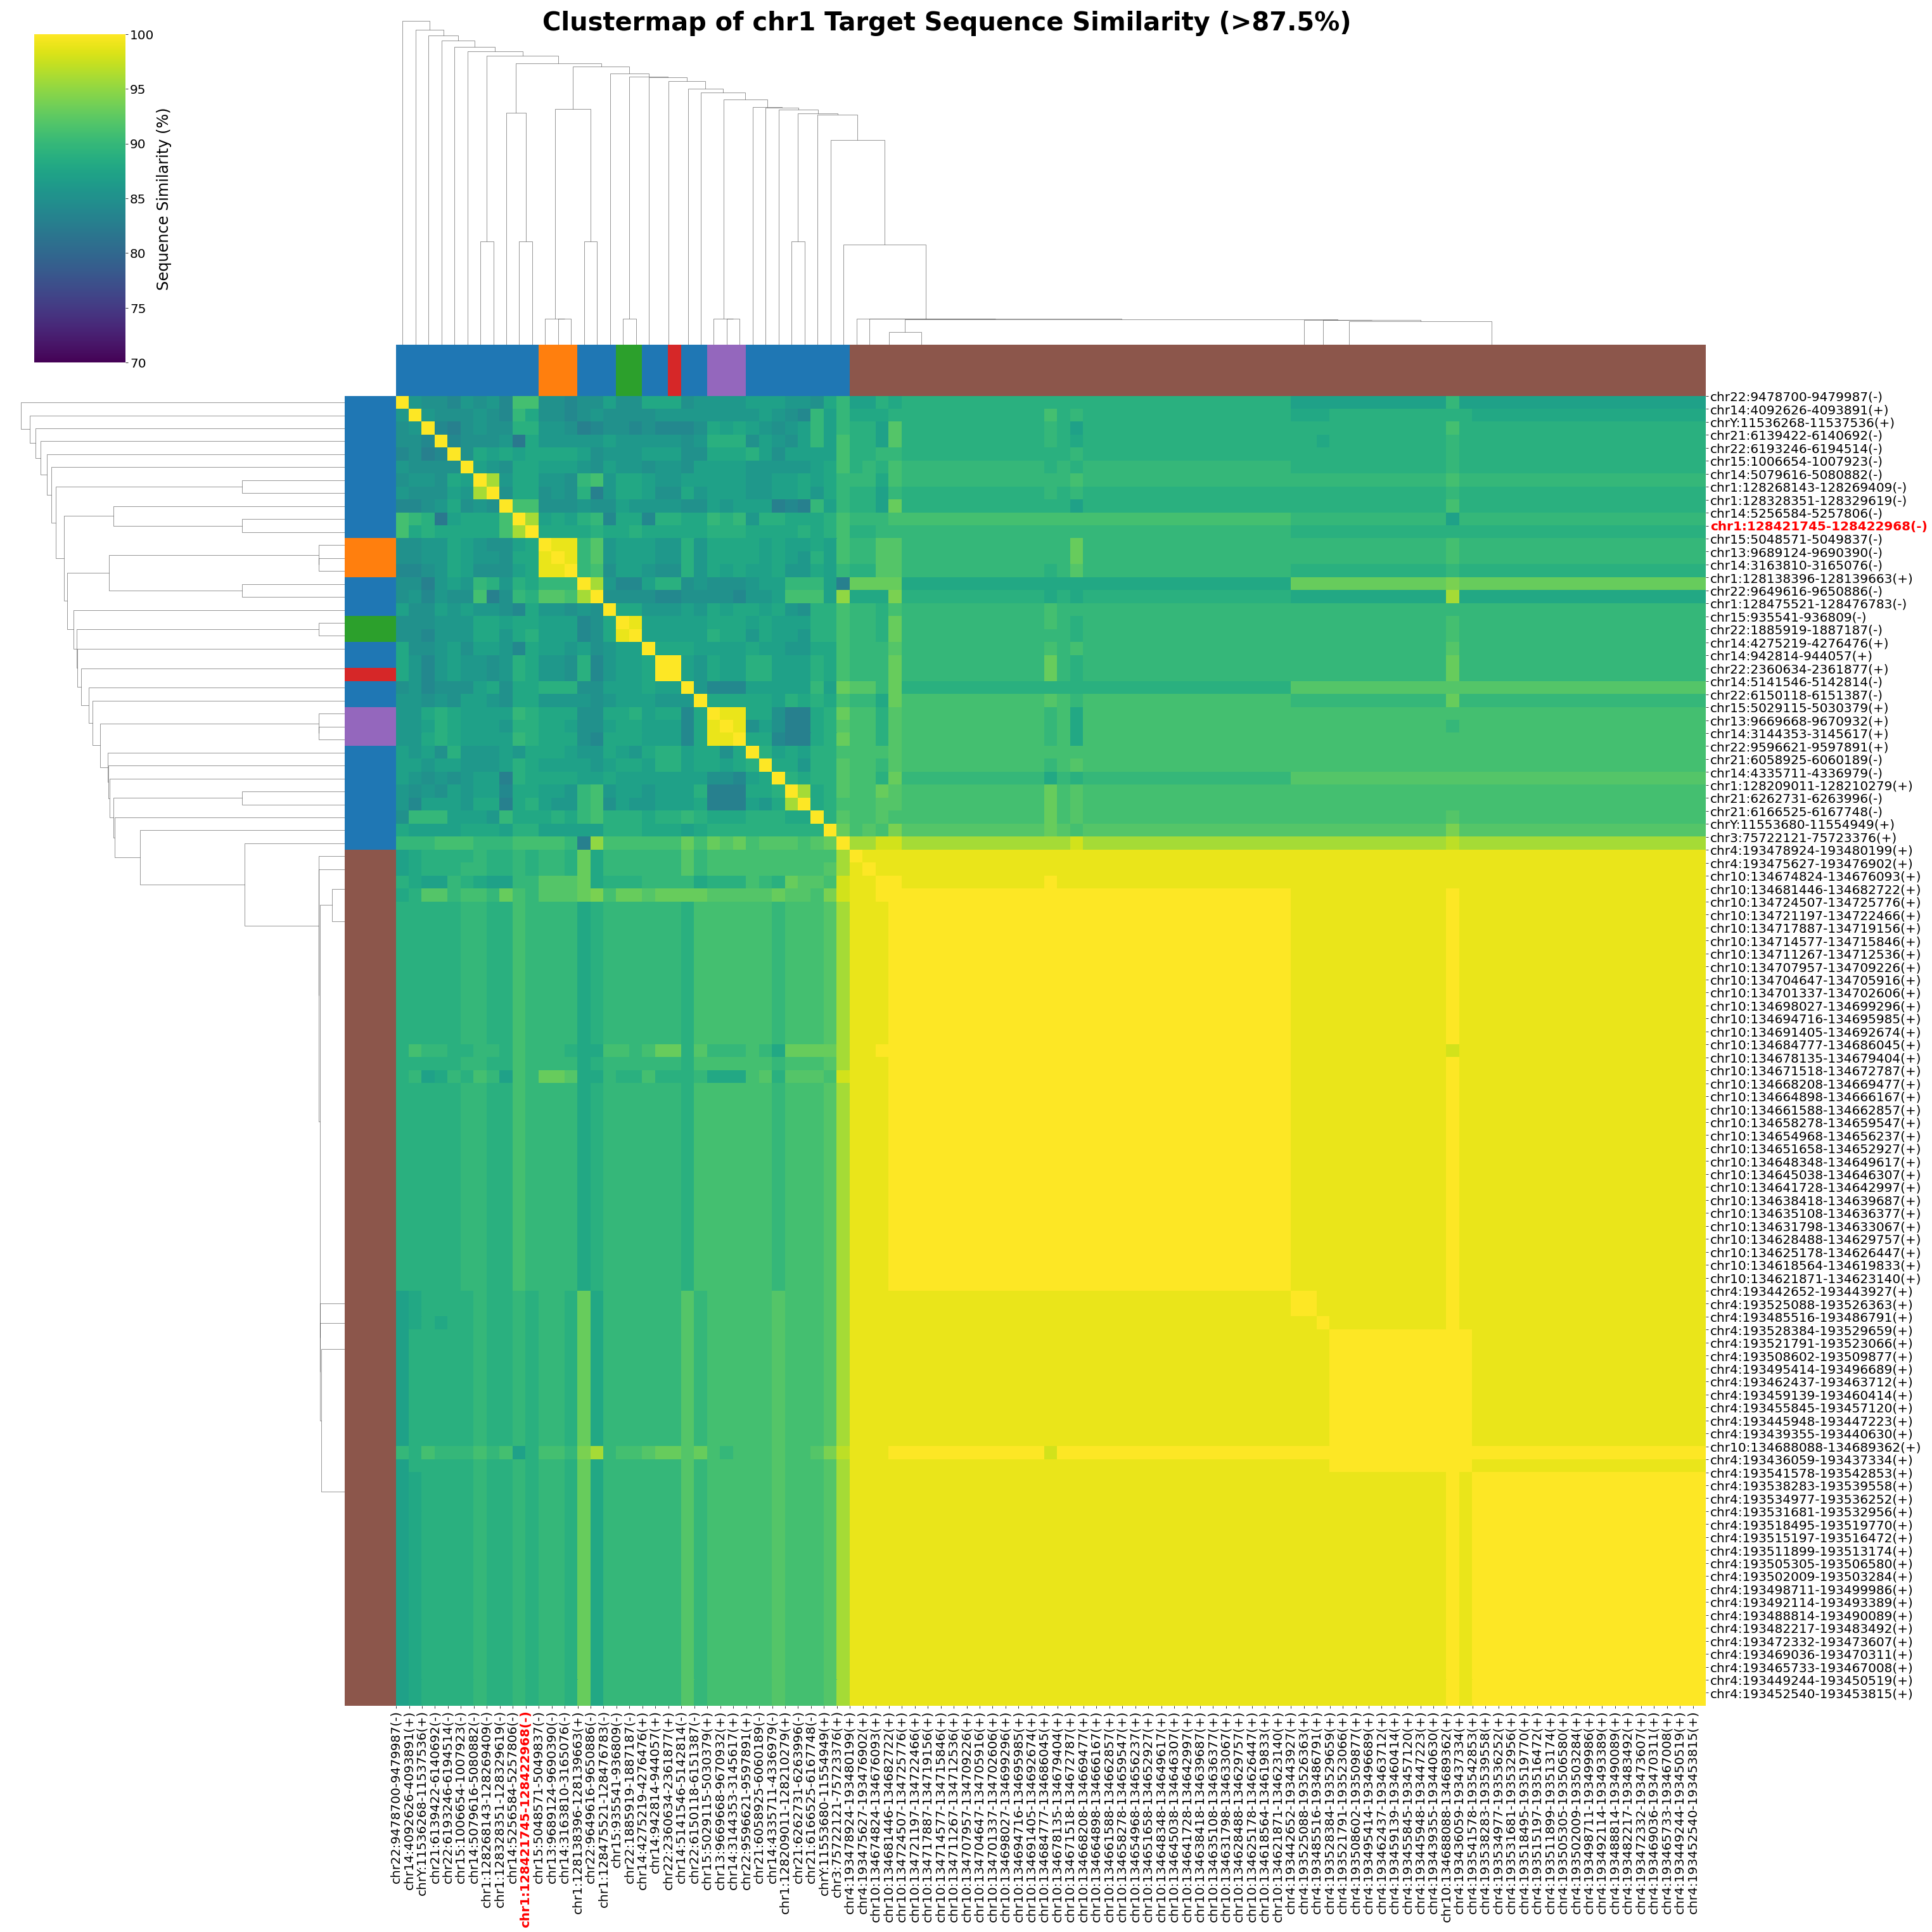

In [ ]:
# the third heatmap is very similar to the first one but I am restiricting it to highly similar matches to the target sequence of interest on chr1
# define again 
sequence_of_interest = "chr1:128421745-128422968(-)"

# load again with appropriate column names and strings to floats
columns = ["Query_ID", "Subject_ID", "%_Identity", "Alignment_Length",
           "Mismatches", "Gap_Openings", "Query_Start", "Query_End", 
           "Subject_Start", "Subject_End", "E-value", "Bit_Score"]
df = pd.read_csv("/lustre/scratch126/casm/team274sb/lr26/T2T/d4z4_sequences_all_with_all.tsv", 
                 sep="\t", names = columns)
df["%_Identity"] = pd.to_numeric(df["%_Identity"], errors="coerce")  

# extract sequence names and generate the similarity matrix (df) with a 70 baseline 
unique_sequences = sorted(set(df["Query_ID"]).union(set(df["Subject_ID"])))
heatmap_df = pd.DataFrame(70, index=unique_sequences, columns=unique_sequences)

# populate with identity values from blast in a symmatrical manner 
for _, row in df.iterrows():
    heatmap_df.at[row["Query_ID"], row["Subject_ID"]] = row["%_Identity"]
    heatmap_df.at[row["Subject_ID"], row["Query_ID"]] = row["%_Identity"]  

### here is the different part ###
# restrict to those which are more than 87.5 inclusive similar to the target including self
if sequence_of_interest in heatmap_df.index:
    similar_sequences = heatmap_df.loc[sequence_of_interest][heatmap_df.loc[sequence_of_interest] >= 87.5].index
    similar_sequences = similar_sequences.union([sequence_of_interest]) 
else: # some error handling
    raise ValueError(f"Sequence '{sequence_of_interest}' not found in dataset!")
# make a subset
subset_heatmap_df = heatmap_df.loc[similar_sequences, similar_sequences]
###

# then proceed again witht he 0-1 conversion and hierarchical clustering
distance_matrix = 1 - (subset_heatmap_df / 100)
condensed_dist = squareform(distance_matrix)
Z = sch.linkage(condensed_dist, method="average")  

# defining the dynamic color threshold, dendrogram colors, correct assignment, map the color well
threshold = 0.15 * max(Z[:, 2])  
dendro = sch.dendrogram(Z, no_plot=True, color_threshold=threshold)
row_colors_dict = {leaf: color for leaf, color in zip(dendro["leaves"], dendro["leaves_color_list"])}
row_colors = [row_colors_dict[i] for i in range(len(subset_heatmap_df))]  

#  make the clustermap
g = sns.clustermap(
    subset_heatmap_df, 
    row_linkage=Z, 
    col_linkage=Z,  
    cmap="viridis", 
    linewidths=0,  
    figsize=(40, 40),
    cbar_kws={'label': 'Sequence Similarity (%)'},
    vmin=70, vmax=100,
    row_colors=row_colors, 
    col_colors=row_colors  
)

#  labels for the clustering and that they all appear
row_labels = [subset_heatmap_df.index[i] for i in g.dendrogram_row.reordered_ind]
col_labels = [subset_heatmap_df.columns[i] for i in g.dendrogram_col.reordered_ind]
g.ax_heatmap.set_yticks(np.arange(len(row_labels)))  
g.ax_heatmap.set_yticklabels(row_labels, fontsize=20)
g.ax_heatmap.set_xticks(np.arange(len(col_labels)))  
g.ax_heatmap.set_xticklabels(col_labels, fontsize=20, rotation=90)
g.ax_cbar.set_ylabel("Sequence Similarity (%)", fontsize=24) 
g.ax_cbar.tick_params(labelsize=20) 
plt.setp(g.ax_heatmap.get_xticklabels(), visible=True)  
plt.setp(g.ax_heatmap.get_yticklabels(), visible=True)

#  make the sequence of interest visible and pretty
for label in g.ax_heatmap.get_yticklabels():
    if label.get_text() == sequence_of_interest:
        label.set_color("red")
        label.set_fontweight("bold")
        label.set_fontsize(20)
for label in g.ax_heatmap.get_xticklabels():
    if label.get_text() == sequence_of_interest:
        label.set_color("red")
        label.set_fontweight("bold")
        label.set_fontsize(20)

# name save and show
plt.title("Clustermap of chr1 Target Sequence Similarity (>87.5%)", fontsize=40, fontweight='bold', y=1, x=10)
plt.savefig("/lustre/scratch126/casm/team274sb/lr26/T2T/d4z4_heatmap_clusters_similar_to_chr1_target.pdf", dpi=300, bbox_inches='tight')
plt.show()
